# Project: Investigate a Dataset - TMDB Movie Data Analysis

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

# <a id='intro'></a>
## Introduction

### Dataset Description 

TMDB dataset contains information about movies collected from The Movie Database (TMDb),including movie genre, runtime, cast, director, production companies, budget, revenue and user ratings.

### Questions for Analysis:
We ask some questions related to Movies, Actors, Directors to give some insights about the dataset, such as:
#### 1- Top Movies of all time by Revenue, Budget, Popularity, User Rating.
#### 2- Top Movies of a specific Year by Revenue, Popularity, User Rating.
#### 3- Top Movies of a specific Genre by Revenue, Popularity, User Rating.
#### 4- Top Movies of a specific Actor by Revenue, Popularity, User Rating.
#### 5- Top Movies of a specific Director by Revenue, Popularity, User Rating.
#### 6- Top Movies of a specific Production Company by Revenue, Popularity, User Rating.
#### 7- Top Actors by Number of Movies.
#### 8- Top Directors by Number of Movies.
#### 9- Top Movie Genres by Number of Movies.
#### 10- Top Production Companies by Revenue, Budget, Number of Movies.
#### 11- Relation between Budget and Revenue.

### Import python packages & TMDB_movies Dataset

In [ ]:
# import python packages and TMDB dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json # to convert str 2 dict

# import tmdb_movies.csv dataset
df_movies = pd.read_csv('tmdb-movies.csv')

### Functions

In [2]:
# Functions
def movie_score(vote_count,vote_average):
    # weighted rating (WR) = (v ÷ (v+m)) × R + (m ÷ (v+m)) × C , where:
    # v = vote_count for the movie
    # R = vote_average for the movie
    # m = minimum votes required to be listed
    # C = mean vote of all movies
    m = vote_count.quantile(0.9)
    C = vote_average.mean()
    WR=[] # weighted average
    for v,R in zip(vote_count,vote_average):
        WR.append((v*R + m*C)/(v+m))
    return np.array(WR)

# plot top (N) movies by revenue, budget, profit
def top_subplot(df,sortedBy,topNumber,labels):
    if type(sortedBy)!=list:
        sortedBy = [sortedBy]
    n = len(sortedBy) # number of subplots
    if n==4:
        fig, ax = plt.subplots(2,2,figsize=(3*n,3*n))
        fig.subplots_adjust(hspace=0.5, wspace=1)
    else:
        fig, ax = plt.subplots(n,1,figsize=(5,5*n))
        fig.subplots_adjust(hspace=0.5)
    if n==1:
        ax = [ax]
    
    I = [0,0,1,1,0,1,0,1]
    for i in range(n):
        df_sorted = df.sort_values([sortedBy[i]],ascending=False)[:topNumber]
        if type(labels)==list:
            ylabels = labels
        elif type(labels)==tuple:
            ylabels = labels[i]
        else: #
            ylabels = df_sorted[labels][:topNumber]
        values = df_sorted[sortedBy[i]][:topNumber]
        if n==4:
#             ax[I[i]][I[i+4]].barh(ylabels,values) # works on old matplotlib library
            ax[I[i]][I[i+4]].barh(range(len(ylabels)), values, tick_label=ylabels) # modified to udacity project workspace
            ax[I[i]][I[i+4]].invert_yaxis() # invert y-axis, descending order
#             ax[I[i]][I[i+4]].set_yticklabels(ylabels)
            ax[I[i]][I[i+4]].set_xlabel(f'{sortedBy[i].title()}')
        else:
#             ax[i].barh(ylabels,values) # works on old matplotlib library
            ax[i].barh(range(len(ylabels)), values, tick_label=ylabels) # modified to udacity project workspace
            ax[i].invert_yaxis() # invert y-axis, descending order
#             ax[i].set_yticklabels(ylabels)
            ax[i].set_xlabel(f'{sortedBy[i].title()}')
    return ax

def column2list(df,column):
    # create augmented lists from columns (cast, genres, directors), convert to dataframe, then groupby
    # split all names by '|' and group them in a list
    column_list = '|'.join([a for a in df[column]]).split('|')
    # repetition number to repeat popularity, vote_score over (cast, genres, directors) members
    repNum = [len(a.split('|')) for a in df[column]]
    popularity_rep,vote_score_rep,total_movies,revenue_rep,budget_rep = [],[],[],[],[]
    for i in range(len(df[column])):
        repNum = len(df[column].values[i].split('|'))
        for j in range(repNum):
            popularity_rep.append(df['popularity'].values[i])
            vote_score_rep.append(df['vote_score'].values[i])
            total_movies.append(1)
            if column in ['production_companies','director','cast']:
                revenue_rep.append(df['revenue_adj'].values[i]/repNum) # assume the revenue is divided over elements
                budget_rep.append(df['budget_adj'].values[i]/repNum) # assume the revenue is divided over elements
    if column in ['production_companies','director','cast']:
        return column_list,popularity_rep,vote_score_rep,total_movies,revenue_rep,budget_rep
    else:
        return column_list,popularity_rep,vote_score_rep,total_movies

In [3]:
# Upgrade pandas to use dataframe.explode() function. 
!pip install --upgrade pandas==0.25.0

Requirement already up-to-date: pandas==0.25.0 in /opt/conda/lib/python3.6/site-packages (0.25.0)


<a id='wrangling'></a>
## Data Wrangling

### General Properties

In [4]:
# Load your data and print out a few lines. Perform operations to inspect data
df_movies.head()

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,135397,tt0369610,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,...,Twenty-two years after the events of Jurassic ...,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/15,5562,6.5,2015,1.379999e+08,1.392446e+09
1,76341,tt1392190,28.419936,150000000,378436354,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,http://www.madmaxmovie.com/,George Miller,What a Lovely Day.,...,An apocalyptic story set in the furthest reach...,120,Action|Adventure|Science Fiction|Thriller,Village Roadshow Pictures|Kennedy Miller Produ...,5/13/15,6185,7.1,2015,1.379999e+08,3.481613e+08
2,262500,tt2908446,13.112507,110000000,295238201,Insurgent,Shailene Woodley|Theo James|Kate Winslet|Ansel...,http://www.thedivergentseries.movie/#insurgent,Robert Schwentke,One Choice Can Destroy You,...,Beatrice Prior must confront her inner demons ...,119,Adventure|Science Fiction|Thriller,Summit Entertainment|Mandeville Films|Red Wago...,3/18/15,2480,6.3,2015,1.012000e+08,2.716190e+08
3,140607,tt2488496,11.173104,200000000,2068178225,Star Wars: The Force Awakens,Harrison Ford|Mark Hamill|Carrie Fisher|Adam D...,http://www.starwars.com/films/star-wars-episod...,J.J. Abrams,Every generation has a story.,...,Thirty years after defeating the Galactic Empi...,136,Action|Adventure|Science Fiction|Fantasy,Lucasfilm|Truenorth Productions|Bad Robot,12/15/15,5292,7.5,2015,1.839999e+08,1.902723e+09
4,168259,tt2820852,9.335014,190000000,1506249360,Furious 7,Vin Diesel|Paul Walker|Jason Statham|Michelle ...,http://www.furious7.com/,James Wan,Vengeance Hits Home,...,Deckard Shaw seeks revenge against Dominic Tor...,137,Action|Crime|Thriller,Universal Pictures|Original Film|Media Rights ...,4/1/15,2947,7.3,2015,1.747999e+08,1.385749e+09


### Drop Duplicates & NaN values

In [5]:
# check for duplicate rows and remove them
# sum(df_movies.duplicated()) # 1 duplicate rows
df_movies.drop_duplicates(inplace=True)

In [6]:
# check for NaN values and drop them if they are important to data analysis. If they are not, leave them.
df_movies.isna().sum()

id                         0
imdb_id                   10
popularity                 0
budget                     0
revenue                    0
original_title             0
cast                      76
homepage                7929
director                  44
tagline                 2824
keywords                1493
overview                   4
runtime                    0
genres                    23
production_companies    1030
release_date               0
vote_count                 0
vote_average               0
release_year               0
budget_adj                 0
revenue_adj                0
dtype: int64

### Drop columns not used in the analysis
- we create a new dataframe 'df' and select the most important columns that will be used in the data analysis process.
- 'production_companies' column has 1030 NaN values, it's a large number of entries to be removed and will not affect movie stats so we replace NaN with an empty string '' to keep the movies.
- we create 'vote_score' as a mix between vote count and vote average, because 10/10 rate based on 1 vote is not better than 9/10 based on 100 votes) to avoid misleading ratings of movies, we define a new factor to give a mix score between votes count and ratings, after some research we found "Shrinkage Estimator" to be the most popular, used by IMDB, how they calculate which movies will make it onto the top 250. It relies on the equation.

In [7]:
# we create a new dataframe 'df' and select the most important columns that will be used in the data analysis process.
columns = ['original_title','release_year','cast','director','genres','runtime','budget_adj','revenue_adj','production_companies','popularity','vote_count','vote_average']

df = df_movies[columns]

# check for NaN values and drop them if they are important to data analysis. If they are not, leave them.
df.isna().sum()

# 'production_companies' column has 1030 NaN values, it's a large number of entries to be removed and will not affect
# movie stats so we replace NaN with '' to keep the movies.
df.fillna('',inplace=True)

# vote count and vote average
# 10/10 rate based on 1 vote is not better than 9/10 based on 100 votes) to avoid misleading ratings of movies, we define a new factor to give a mix score between votes count and ratings, after some research we found "Shrinkage Estimator" to be the most popular, used by IMDB, how they calculate which movies will make it onto the top 250. It relies on the equation.
# we defined movie_score(vote_count,vote_average) function to give the new vote_score
df['vote_score'] = movie_score(df['vote_count'],df['vote_average'])

df_movies.head()

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:4239: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  **kwargs
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,135397,tt0369610,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,...,Twenty-two years after the events of Jurassic ...,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/15,5562,6.5,2015,1.379999e+08,1.392446e+09
1,76341,tt1392190,28.419936,150000000,378436354,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,http://www.madmaxmovie.com/,George Miller,What a Lovely Day.,...,An apocalyptic story set in the furthest reach...,120,Action|Adventure|Science Fiction|Thriller,Village Roadshow Pictures|Kennedy Miller Produ...,5/13/15,6185,7.1,2015,1.379999e+08,3.481613e+08
2,262500,tt2908446,13.112507,110000000,295238201,Insurgent,Shailene Woodley|Theo James|Kate Winslet|Ansel...,http://www.thedivergentseries.movie/#insurgent,Robert Schwentke,One Choice Can Destroy You,...,Beatrice Prior must confront her inner demons ...,119,Adventure|Science Fiction|Thriller,Summit Entertainment|Mandeville Films|Red Wago...,3/18/15,2480,6.3,2015,1.012000e+08,2.716190e+08
3,140607,tt2488496,11.173104,200000000,2068178225,Star Wars: The Force Awakens,Harrison Ford|Mark Hamill|Carrie Fisher|Adam D...,http://www.starwars.com/films/star-wars-episod...,J.J. Abrams,Every generation has a story.,...,Thirty years after defeating the Galactic Empi...,136,Action|Adventure|Science Fiction|Fantasy,Lucasfilm|Truenorth Productions|Bad Robot,12/15/15,5292,7.5,2015,1.839999e+08,1.902723e+09
4,168259,tt2820852,9.335014,190000000,1506249360,Furious 7,Vin Diesel|Paul Walker|Jason Statham|Michelle ...,http://www.furious7.com/,James Wan,Vengeance Hits Home,...,Deckard Shaw seeks revenge against Dominic Tor...,137,Action|Crime|Thriller,Universal Pictures|Original Film|Media Rights ...,4/1/15,2947,7.3,2015,1.747999e+08,1.385749e+09


### General Statistics

In [8]:
# general stats: dataset contains movies from 1960 to 2015.
# on average runtime=102 min, budget=1.75e7, revenue= 5.14e7
df.describe()

,release_year,runtime,budget_adj,revenue_adj,popularity,vote_count,vote_average,vote_score
count,10865.000000,10865.000000,1.086500e+04,1.086500e+04,10865.000000,10865.000000,10865.000000,10865.000000
mean,2001.321859,102.071790,1.754989e+07,5.136900e+07,0.646446,217.399632,5.975012,6.032452
std,12.813260,31.382701,3.430753e+07,1.446383e+08,1.000231,575.644627,0.935138,0.248239
min,1960.000000,0.000000,0.000000e+00,0.000000e+00,0.000065,10.000000,1.500000,4.699777
25%,1995.000000,90.000000,0.000000e+00,0.000000e+00,0.207575,17.000000,5.400000,5.941867
50%,2006.000000,99.000000,0.000000e+00,0.000000e+00,0.383831,38.000000,6.000000,5.978130
75%,2011.000000,111.000000,2.085325e+07,3.370173e+07,0.713857,146.000000,6.600000,6.032596
max,2015.000000,900.000000,4.250000e+08,2.827124e+09,32.985763,9767.000000,9.200000,8.203275


- Dataset contains movies from 1960 to 2015.
- on average runtime=102 min, budget=1.75e7, revenue= 5.14e7, vote_count= 217.4
- but it shows outlier numbers; a movie with 0 min and 900 min runtime, budget = 0, revenue = 0
- Let's check them!`

In [9]:
sum(df['runtime']==0),sum(df['revenue_adj']==0),sum(df['budget_adj']==0)

(31, 6016, 5696)

- dataset has 31 movies with runtime = 0
- dataset has 6016 movies with revenue_adj = 0
- dataset has 5696 movies with budget_adj = 0
- It's a large number of movies, we can't remove them, but they will be replaced by the average value of their column

In [10]:
for column in ['runtime','revenue_adj','budget_adj']:
    df[column] = df[column].replace(0,df[column].mean()) # replace 0 with average value of the column
    
df.describe()
# sum(df['runtime']==0), sum(df['revenue_adj']==0), sum(df['budget_adj']==0)  = (0, 0, 0)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,release_year,runtime,budget_adj,revenue_adj,popularity,vote_count,vote_average,vote_score
count,10865.000000,10865.000000,1.086500e+04,1.086500e+04,10865.000000,10865.000000,10865.000000,10865.000000
mean,2001.321859,102.363021,2.675046e+07,7.981225e+07,0.646446,217.399632,5.975012,6.032452
std,12.813260,30.904043,3.051007e+07,1.365647e+08,1.000231,575.644627,0.935138,0.248239
min,1960.000000,2.000000,9.210911e-01,2.370705e+00,0.000065,10.000000,1.500000,4.699777
25%,1995.000000,90.000000,1.754989e+07,5.136900e+07,0.207575,17.000000,5.400000,5.941867
50%,2006.000000,99.000000,1.754989e+07,5.136900e+07,0.383831,38.000000,6.000000,5.978130
75%,2011.000000,111.000000,2.085325e+07,5.136900e+07,0.713857,146.000000,6.600000,6.032596
max,2015.000000,900.000000,4.250000e+08,2.827124e+09,32.985763,9767.000000,9.200000,8.203275


<a id='eda'></a>
## Exploratory Data Analysis

1- Top Movies of all time by Revenue, Budget, Popularity, User Rating.

2- Top Movies of a specific Year by Revenue, Popularity, User Rating.

3- Top Movies of a specific Genre by Revenue, Popularity, User Rating.

4- Top Movies of a specific Actor by Revenue, Popularity, User Rating.

5- Top Movies of a specific Director by Revenue, Popularity, User Rating.

6- Top Movies of a specific Production Company by Revenue, Popularity, User Rating.

7- Top Actors by Number of Movies.

8- Top Directors by Number of Movies.

9- Top Movie Genres by Number of Movies.

10- Top Production Companies by Revenue, Budget, Number of Movies.

11- Relation between Budget and Revenue.

### 1- Top Movies of all time by Revenue, Budget, Popularity, User Rating.
- Top movie of all time by revenue is 'Avatar'.
- Top movie of all time by budget is 'The Warrior's Way'.
- Top movie of all time by popularity is 'Jurassic World'.
- Top movie of all time by user rating is 'The Shawshank Redemption'.

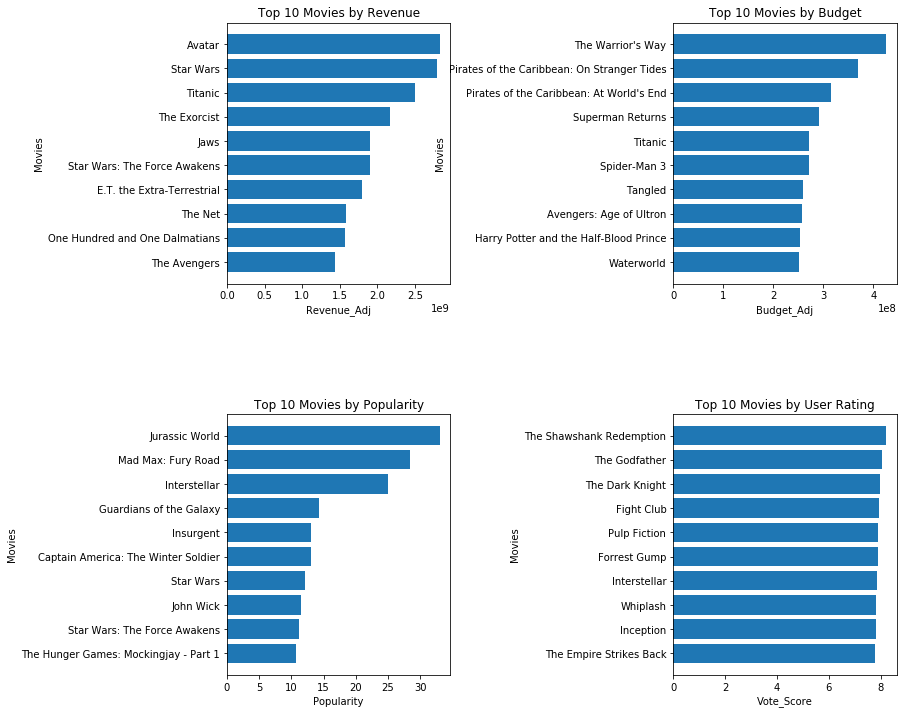

In [11]:
# 1- Top Movies of all time by Revenue, Budget, Popularity, User Rating.
topNum = 10
fig = top_subplot(df,['revenue_adj','budget_adj','popularity','vote_score'],topNum,'original_title')

title_txt = ['Revenue','Budget','Popularity','User Rating']
for i in [0,1]:
    for j in [0,1]:
        fig[i][j].set_title(f'Top {topNum} Movies by {title_txt[2*i+j]}');
        fig[i][j].set_ylabel('Movies');

### 2- Top Movies of a specific Year by Revenue, Budget, Popularity, User Rating.
- Top movie in 2012 by revenue is 'The Avengers'.
- Top movie in 2012 by budget is 'John Carter'.
- Top movie in 2012 by popularity is 'The Avengers'.
- Top movie in 2012 by user rating is 'Django Unchained'.

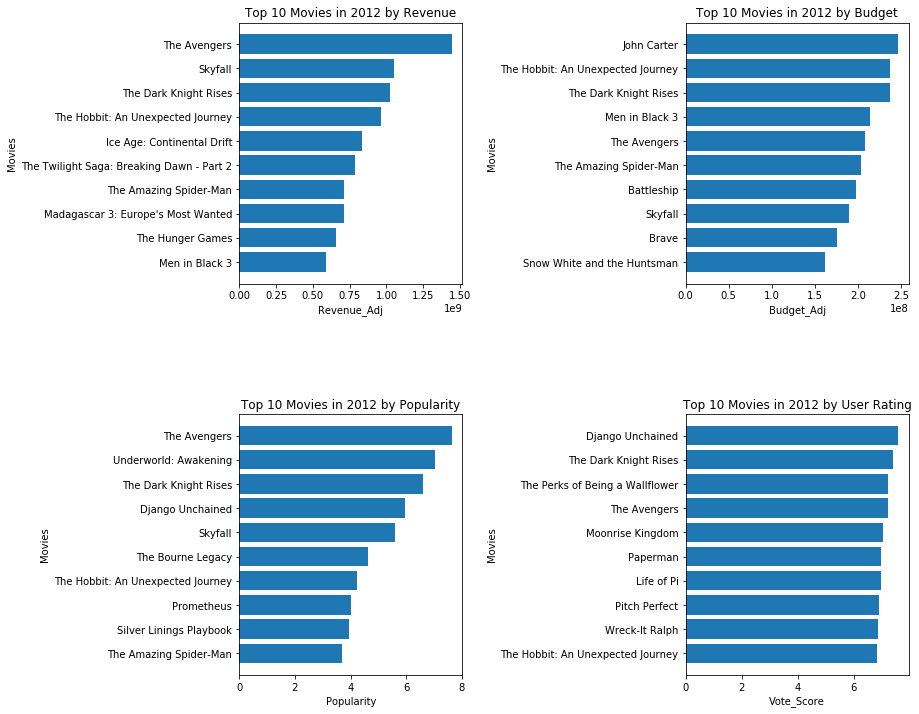

In [12]:
# 2- Top Movies in a specific Year by Revenue, Budget, Popularity, User Rating.
topNum = 10
movie_year = 2012
df_genres_s = df[df['release_year']==movie_year]
fig = top_subplot(df_genres_s,['revenue_adj','budget_adj','popularity','vote_score'],topNum,'original_title')

title_txt = ['Revenue','Budget','Popularity','User Rating']
for i in [0,1]:
    for j in [0,1]:
        fig[i][j].set_title(f'Top {topNum} Movies in {movie_year} by {title_txt[2*i+j]}');
        fig[i][j].set_ylabel('Movies');

### 3- Top Movies of a specific Genre by Revenue, Budget, Popularity, User Rating.
- Top 'Animation' movie by revenue is 'One Hundred and One Dalmatians'.
- Top 'Animation' movie by budget is 'Tangled'.
- Top 'Animation' movie by popularity is 'Big Hero 6'.
- Top 'Animation' movie by user rating is 'Inside Out'.

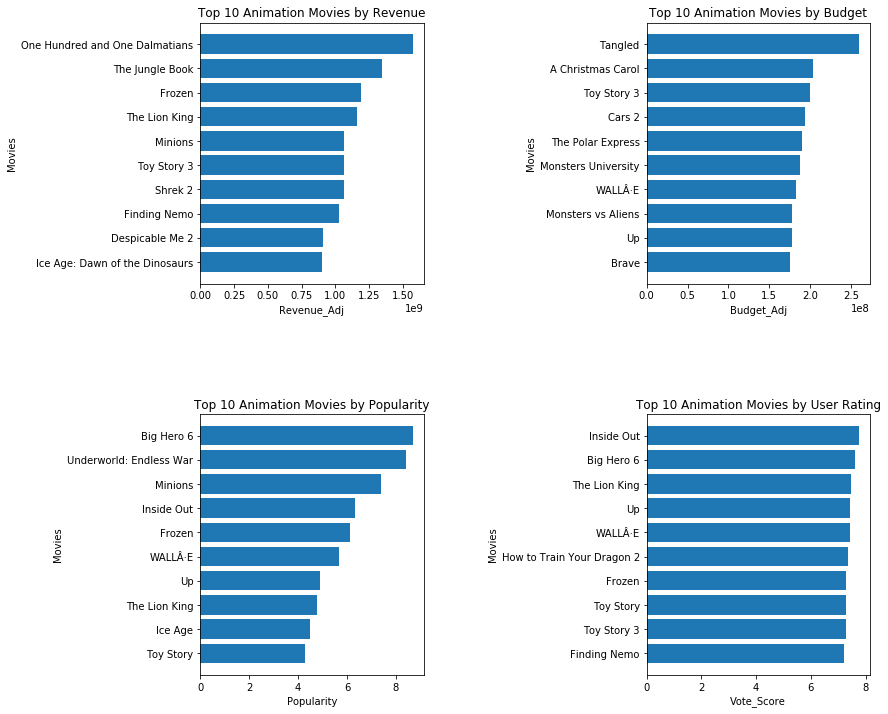

In [13]:
# 3- Top Movies of a specific Genre by Revenue, Budget, Popularity, User Rating.
topNum = 10
movie_genre = 'Animation'
df_genres_s = df[df['genres'].str.contains(movie_genre)]
fig = top_subplot(df_genres_s,['revenue_adj','budget_adj','popularity','vote_score'],topNum,'original_title')

title_txt = ['Revenue','Budget','Popularity','User Rating']
for i in [0,1]:
    for j in [0,1]:
        fig[i][j].set_title(f'Top {topNum} {movie_genre} Movies by {title_txt[2*i+j]}');
        fig[i][j].set_ylabel('Movies');

### 4- Top Movies for a specific Actor by Revenue, Budget, Popularity, User Rating.
- Top 'Leonardo DiCaprio' movie by revenue is 'Titanic'.
- Top 'Leonardo DiCaprio' movie by budget is 'Titanic'.
- Top 'Leonardo DiCaprio' movie by popularity is 'Inception'.
- Top 'Leonardo DiCaprio' movie by user rating is 'Inception'.

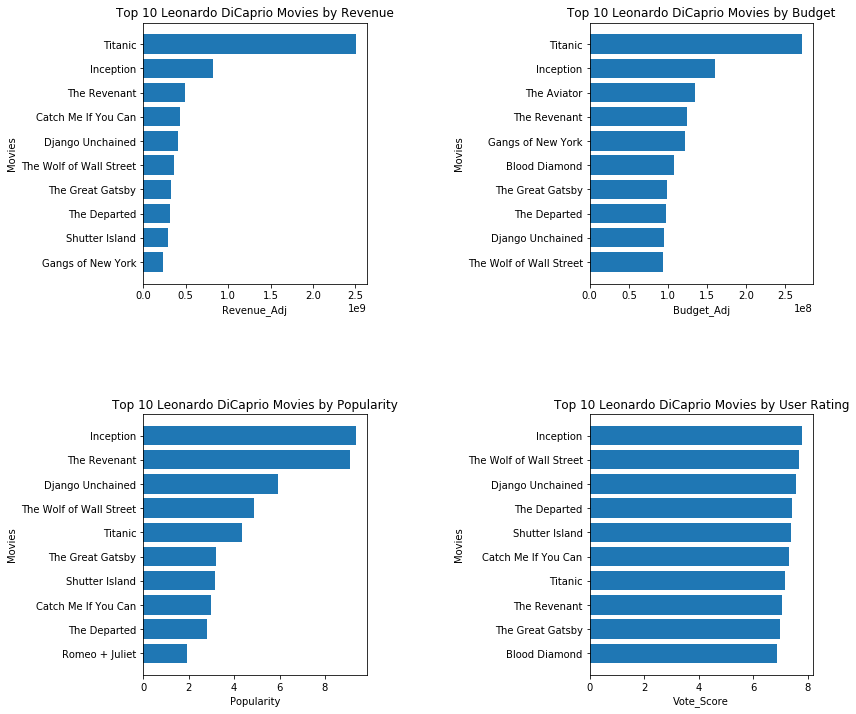

In [14]:
# 4- Top Movies for a specific Actor by Revenue, Budget, Popularity, User Rating.
topNum = 10
cast_s = 'Leonardo DiCaprio' # Dwayne Johnson, Christian Bale, Dwayne Johnson, Tom Hanks, Tom Cruise
df_cast_s = df[df['cast'].str.contains(cast_s)]
fig = top_subplot(df_cast_s,['revenue_adj','budget_adj','popularity','vote_score'],topNum,'original_title')

title_txt = ['Revenue','Budget','Popularity','User Rating']
for i in [0,1]:
    for j in [0,1]:
        fig[i][j].set_title(f'Top {topNum} {cast_s} Movies by {title_txt[2*i+j]}');
        fig[i][j].set_ylabel('Movies');

### 5- Top Movies for a specific Director by Revenue, Budget, Popularity, User Rating.
- Top 'Christopher Nolan' movie by revenue is 'The Dark Knight Rises'.
- Top 'Christopher Nolan' movie by budget is 'The Dark Knight Rises'.
- Top 'Christopher Nolan' movie by popularity is 'Interstellar'.
- Top 'Christopher Nolan' movie by user rating is 'The Dark Knight'.

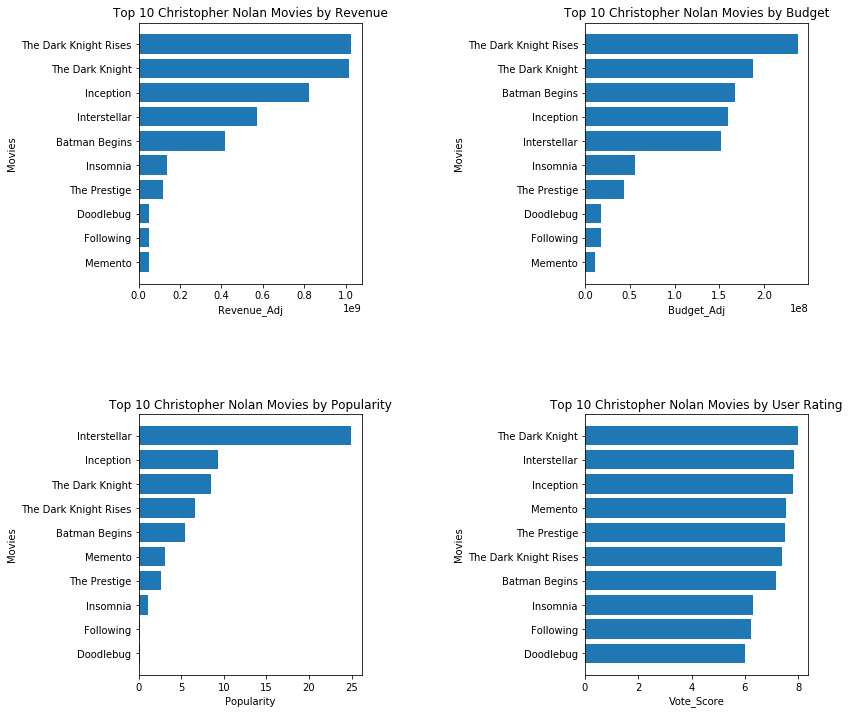

In [15]:
# 5- Top Movies for a specific Director by Revenue, Budget, Popularity, User Rating.
topNum = 10
director_s = 'Christopher Nolan' # James Cameron
df_director_s = df[df['director'].str.contains(director_s)]
fig = top_subplot(df_director_s,['revenue_adj','budget_adj','popularity','vote_score'],topNum,'original_title')

title_txt = ['Revenue','Budget','Popularity','User Rating']
for i in [0,1]:
    for j in [0,1]:
        fig[i][j].set_title(f'Top {topNum} {director_s} Movies by {title_txt[2*i+j]}');
        fig[i][j].set_ylabel('Movies');

### 6- Top Movies of a specific Production Company by Revenue, Budget, Popularity, User Rating.
- Top 'Marvel' movie by revenue is 'The Avengers'.
- Top 'Marvel' movie by revenue is 'Spider-Man 3'.
- Top 'Marvel' movie by revenue is 'Guardians of the Galaxy'.
- Top 'Marvel' movie by revenue is 'Guardians of the Galaxy'.

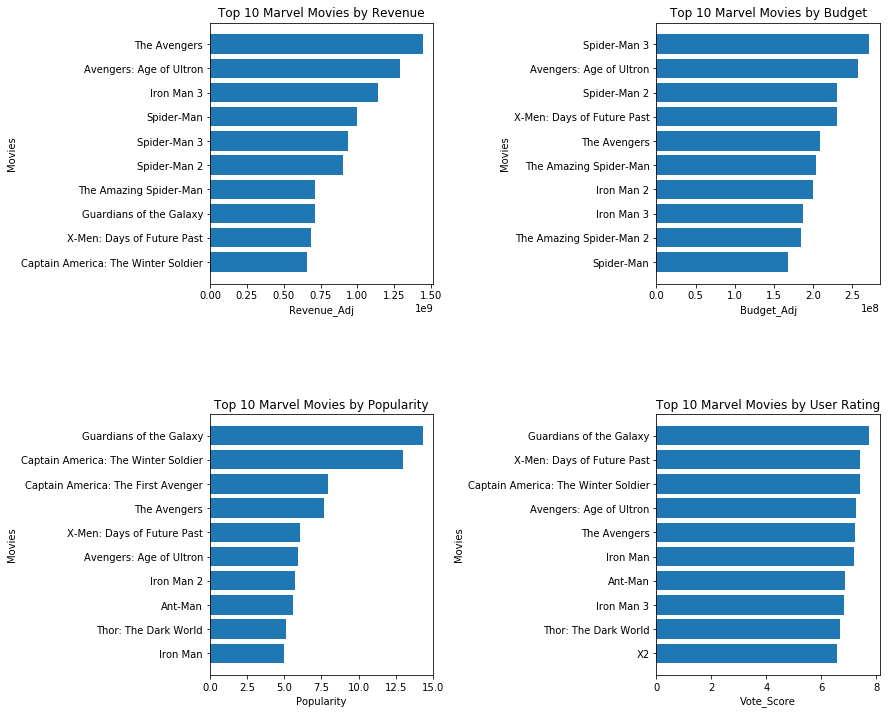

In [16]:
# 6- Top Movies of a specific Production Company by Revenue, Budget, Popularity, User Rating.
topNum = 10
prod_s = 'Marvel' # Warner Bros, Universal Pictures, Disney
df_prod_s = df[df['production_companies'].str.contains(prod_s)]
fig = top_subplot(df_prod_s,['revenue_adj','budget_adj','popularity','vote_score'],topNum,'original_title')

title_txt = ['Revenue','Budget','Popularity','User Rating']
for i in [0,1]:
    for j in [0,1]:
        fig[i][j].set_title(f'Top {topNum} {prod_s} Movies by {title_txt[2*i+j]}');
        fig[i][j].set_ylabel('Movies');

### 7- Top Production Companies by Revenue, Budget, Number of Movies
- Top production company by revenue is 'Paramount Pictures'.
- Top production company by budget is 'Warner Bros'.
- Top production company by number of movies is 'Universal Pictures'.

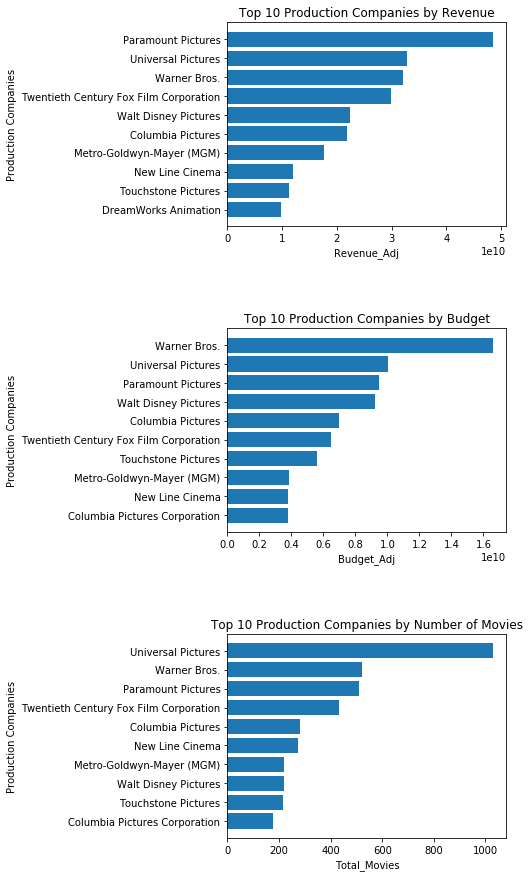

In [17]:
# 7- Top Production Companies by Revenue, Budget, Number of Movies
prod_comp_all, p, v, total_movies,prod_rev,prod_bud = column2list(df,'production_companies')
df_prodcomp_0= pd.DataFrame({'prod_comp_all':prod_comp_all,'total_movies':total_movies,'revenue_adj':prod_rev,'budget_adj':prod_bud})
df_prodcomp = df_prodcomp_0.groupby('prod_comp_all').sum()
prod_rev = df_prodcomp.sort_values(by='revenue_adj', ascending=False)
prod_bud = df_prodcomp.sort_values(by='budget_adj', ascending=False)
prod_mov = df_prodcomp.sort_values(by='total_movies', ascending=False)
# Plot
topNum = 10
prod_mov.drop(prod_mov.index[list(prod_mov.index).index('')], inplace=True) # remove '' entries to avoid showing in plot
labels = (list(prod_rev.index[1:topNum+1]),list(prod_bud.index[1:topNum+1]),list(prod_mov.index[:topNum]))
fig = top_subplot(df_prodcomp,['revenue_adj','budget_adj','total_movies'],topNum,labels);
fig[0].set_title(f'Top {topNum} Production Companies by Revenue');
fig[1].set_title(f'Top {topNum} Production Companies by Budget');
fig[2].set_title(f'Top {topNum} Production Companies by Number of Movies');
for i in range(3):
    fig[i].set_ylabel('Production Companies');

### 8- Top Directors by Revenue, Budget, Number of Movies
- Top director by revenue is 'Steven Spielberg'.
- Top director by budget is 'Steven Spielberg'.
- Top director by number of movies is 'Woody Allen'.

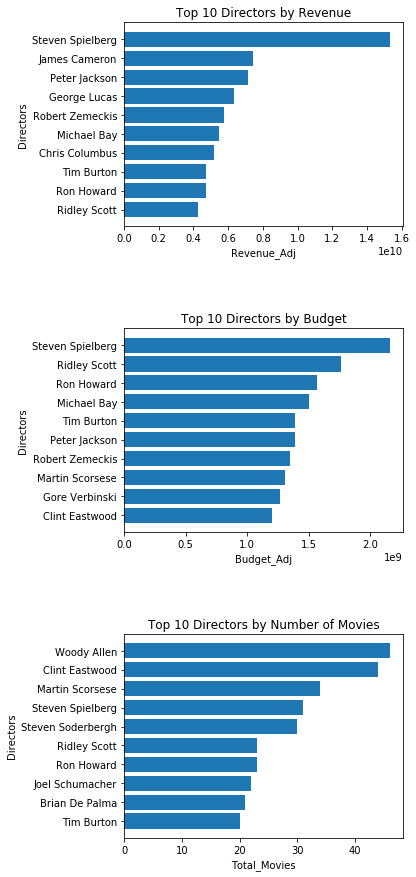

In [18]:
# 8- Top Directors by Revenue, Budget, Number of Movies
dir_all, p, v, total_movies,dir_rev,dir_bud = column2list(df,'director')
df_dir_0= pd.DataFrame({'dir_all':dir_all,'total_movies':total_movies,'revenue_adj':dir_rev,'budget_adj':dir_bud})
df_dir = df_dir_0.groupby('dir_all').sum()
dir_rev = df_dir.sort_values(by='revenue_adj', ascending=False)
dir_bud = df_dir.sort_values(by='budget_adj', ascending=False)
dir_mov = df_dir.sort_values(by='total_movies', ascending=False)
# Plot
topNum = 10
dir_mov.drop(dir_mov.index[list(dir_mov.index).index('')], inplace=True) # remove '' entries to avoid showing in plot
labels = (list(dir_rev.index[:topNum]),list(dir_bud.index[:topNum]),list(dir_mov.index[:topNum]))
fig = top_subplot(df_dir,['revenue_adj','budget_adj','total_movies'],topNum,labels);
fig[0].set_title(f'Top {topNum} Directors by Revenue');
fig[1].set_title(f'Top {topNum} Directors by Budget');
fig[2].set_title(f'Top {topNum} Directors by Number of Movies');
for i in range(3):
    fig[i].set_ylabel('Directors');

### 9- Top Actors by Revenue, Budget, Number of Movies
- Top actor by revenue is 'Harrison Ford'.
- Top actor by budget is 'Johnny Depp'.
- Top actor by number of movies is 'Robert De Niro'.

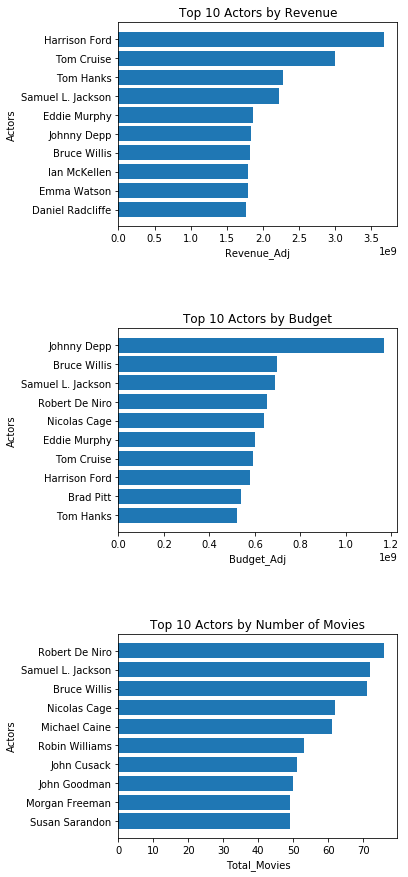

In [19]:
# 9- Top Actors by Revenue, Budget, Number of Movies
cast_all, p, v, total_movies,cast_rev,cast_bud = column2list(df,'cast')
df_cast_0= pd.DataFrame({'cast_all':cast_all,'total_movies':total_movies,'revenue_adj':cast_rev,'budget_adj':cast_bud})
df_cast = df_cast_0.groupby('cast_all').sum()
cast_rev = df_cast.sort_values(by='revenue_adj', ascending=False)
cast_bud = df_cast.sort_values(by='budget_adj', ascending=False)
cast_mov = df_cast.sort_values(by='total_movies', ascending=False)
# Plot
topNum = 10
cast_mov.drop(cast_mov.index[list(cast_mov.index).index('')], inplace=True) # remove '' entries to avoid showing in plot
labels = (list(cast_rev.index[1:topNum+1]),list(cast_bud.index[1:topNum+1]),list(cast_mov.index[:topNum]))
fig = top_subplot(df_cast,['revenue_adj','budget_adj','total_movies'],topNum,labels);
fig[0].set_title(f'Top {topNum} Actors by Revenue');
fig[1].set_title(f'Top {topNum} Actors by Budget');
fig[2].set_title(f'Top {topNum} Actors by Number of Movies');
for i in range(3):
    fig[i].set_ylabel('Actors');

### 10- Top Movie Genres by Number of Movies
- The drama genre is the most popular movie genre over years.

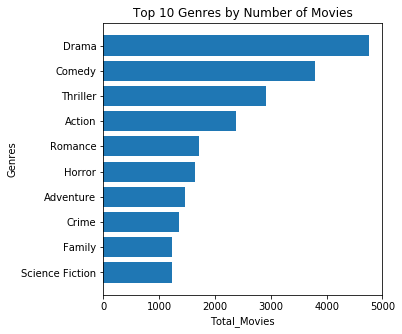

In [20]:
# 10- Top Movie Genres by Number of Movies
genres_all, p, v, total_movies = column2list(df,'genres')
df_genres_0= pd.DataFrame({'genres_all':genres_all,'total_movies':total_movies})
df_genres = df_genres_0.groupby('genres_all').sum().sort_values(by='total_movies', ascending=False)
# Plot
# remove '' entries to avoid showing in plot
topNum = 10
df_genres.drop(df_genres.index[list(df_genres.index).index('')], inplace=True)
labels = list(df_genres.index[:topNum])
fig = top_subplot(df_genres,['total_movies'],topNum,labels);
fig[0].set_title(f'Top {topNum} Genres by Number of Movies');
fig[0].set_ylabel('Genres');

### 11- Relation between Budget and Revenue.
- YES there is a positive correlation between Budget and Revenue

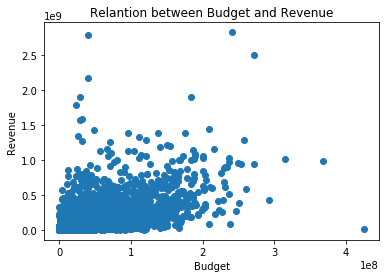

In [21]:
# 11- Relation between Budget and Revenue.
plt.scatter(df['budget_adj'],df['revenue_adj']);
plt.xlabel('Budget');
plt.ylabel('Revenue');
plt.title('Relantion between Budget and Revenue');

### 12- Budget, Revenue, Total Movies over years (1960-2015)
- It's clear that Budget, Revenue and Total Movies are increasing over years.

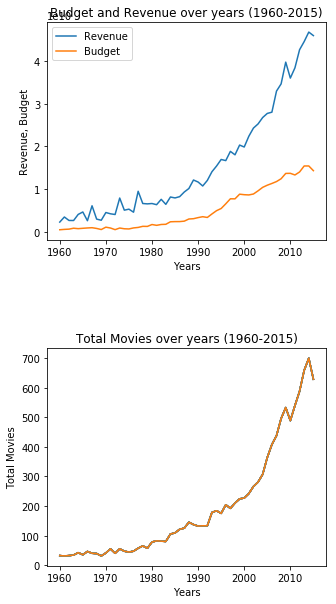

In [22]:
# group years and sum revenue, budget 
df_years = df.groupby('release_year').sum().sort_values(by='release_year')

fig, ax = plt.subplots(2,1,figsize=(5,10))
fig.subplots_adjust(hspace=0.5)

ax[0].plot(list(df_years.index), df_years['revenue_adj']);
ax[0].plot(list(df_years.index), df_years['budget_adj']);
ax[0].set_xlabel('Years');
ax[0].set_ylabel('Revenue, Budget');
ax[0].legend(['Revenue', 'Budget']);
ax[0].set_title('Budget and Revenue over years (1960-2015)');

ax[1].plot(list(df_years.index), df.groupby('release_year').count().sort_values(by='release_year'));
ax[1].set_xlabel('Years');
ax[1].set_ylabel('Total Movies');
ax[1].set_title('Total Movies over years (1960-2015)');


<a id='conclusions'></a>
## Conclusions
- Top movie of all time by revenue is 'Avatar'.
- Top movie of all time by budget is 'The Warrior's Way'.
- Top movie of all time by popularity is 'Jurassic World'.
- Top movie of all time by user rating is 'The Shawshank Redemption'.
- Top production company by revenue is 'Paramount Pictures'.
- Top production company by budget is 'Warner Bros'.
- Top production company by number of movies is 'Universal Pictures'.
- Top director by revenue is 'Steven Spielberg'.
- Top director by budget is 'Steven Spielberg'.
- Top director by number of movies is 'Woody Allen'.
- Top actor by revenue is 'Harrison Ford'.
- Top actor by budget is 'Johnny Depp'.
- Top actor by number of movies is 'Robert De Niro'.
- Top movie genre over years is 'Drama.
- There is a positive correlation between Budget and Revenue.
- It's clear that Budget, Revenue and Total Movies are increasing over years.

## Limitations
- We have used TMBD Movies dataset for our analysis and worked with budget, revenue, popularity and user ratings. Our analysis is limited to only the provided dataset. For example, the dataset does not confirm that every release of every director and actor is listed, also the latest year is 2015.
- Cast is only limited to 5 actors, which mean that not all actors are counted and that may affect on actors statistics.
- Many movies have budget_adj and revenue_adj equal to zero, this may have an effect on budget and revenue analysis.
- Dropping missing or Null values from variables of our interest might skew our analysis and could show unintentional bias towards the relationship being analyzed.

In [23]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])

0